In [1]:
# Installation ipyvolume
# !conda install -c conda-forge ipyvolume

In [2]:
import matplotlib.pyplot as plt

from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.integrate as integrate
import scipy.special as spe

# Increase resolution for retina display
%config InlineBackend.figure_format = 'retina'

# Load interactive widgets
import ipywidgets as widgets
import ipyvolume as ipv

## Plotting the radial part of wavefunction 

<br>

>$\displaystyle R_{nl}(r) = \sqrt{\left( \frac{2}{na}\right)^3 \frac{(n -l -1)!}{2n(n +l)!}} e^{-r/na}
\left( \frac{2r}{na} \right)^l \, L_{n -l -1}^{2l +1} \left( \frac{2r}{na} \right)$

<br>
In what follows we will adopt atomic units

> $a=1, \hbar=1, \; \mu=1, \;e=1$

In [3]:
def psi_R(r, n=1, l=0):

    coeff = np.sqrt((2.0/n)**3 *spe.factorial(n-l-1) /(2.0*n*spe.factorial(n+l)))   
    laguerre = spe.assoc_laguerre(2.0*r/n, n-l-1, 2*l+1)
    
    return coeff * np.exp(-r/n) * (2.0*r/n)**l * laguerre

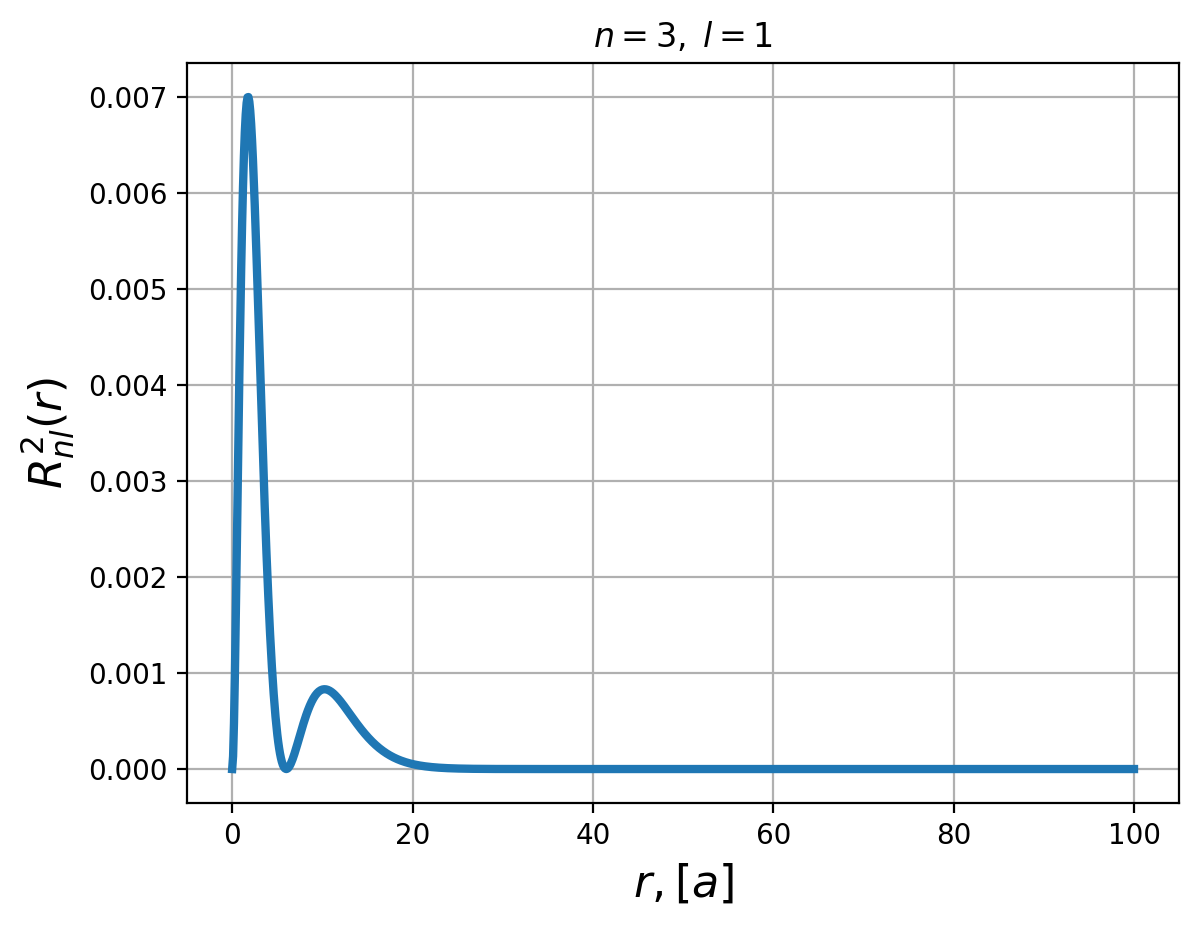

In [4]:
r = np.linspace(0, 100, 1000)
R = psi_R(r, n=3, l=1)

plt.plot(r, R**2, lw=3)

plt.grid()
plt.title('$n=3, \;l=1$')
plt.xlabel('$r, [a]$', fontsize=16)
plt.ylabel('$R_{nl}^2(r)$', fontsize=16)

plt.show()

In [5]:
nmax = 10

@widgets.interact(n = np.arange(1, nmax, 1), l = np.arange(0, nmax -1, 1))

def plot_radial(n=1, l=0):
    
    r = np.linspace(0, 250, 10000)   
    psi2 = psi_R(r, n, l)**2 *r**2  # Probability as a function of radial distance goes like r^2 R(r)
    
    plt.plot(r, psi2, lw=2, color='red')  
    
    plt.xlabel('$r, [a]$')
    plt.ylabel('Electron probabilty, $r^2 R_{nl}^2(r)$')
    
    rmax = n**2 *(1 +0.5 *(1 -l *(l +1) /n**2))   
    plt.xlim([0, 2.2*rmax])


interactive(children=(Dropdown(description='n', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Dropdown(descri…

## Plotting the angular part of wavefunction: Spherical Harmonics 

<br>

>$\displaystyle Y_l^{m}(\phi,\theta)=\epsilon \sqrt{\frac{(21 +1)}{4\pi} \frac{(l -|m|)!}{(l +|m|)!}} P_l^{|m|}(\cos\phi) e^{im\theta} $

In [6]:
def psi_ang(phi, theta, l=0, m=0):
    
    # We use real part of the spherical harmonics which is physically identical to imaginary counterparts
    sphHarm = spe.sph_harm(m, l, theta, phi)
    
    return sphHarm.real


In [7]:
phi, theta = np.linspace(0, np.pi, 100), np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

Ylm = psi_ang(phi, theta, l=2, m=0)


In [8]:
x = np.sin(phi) * np.cos(theta) * abs(Ylm)
y = np.sin(phi) * np.sin(theta) * abs(Ylm)
z = np.cos(phi) * abs(Ylm)


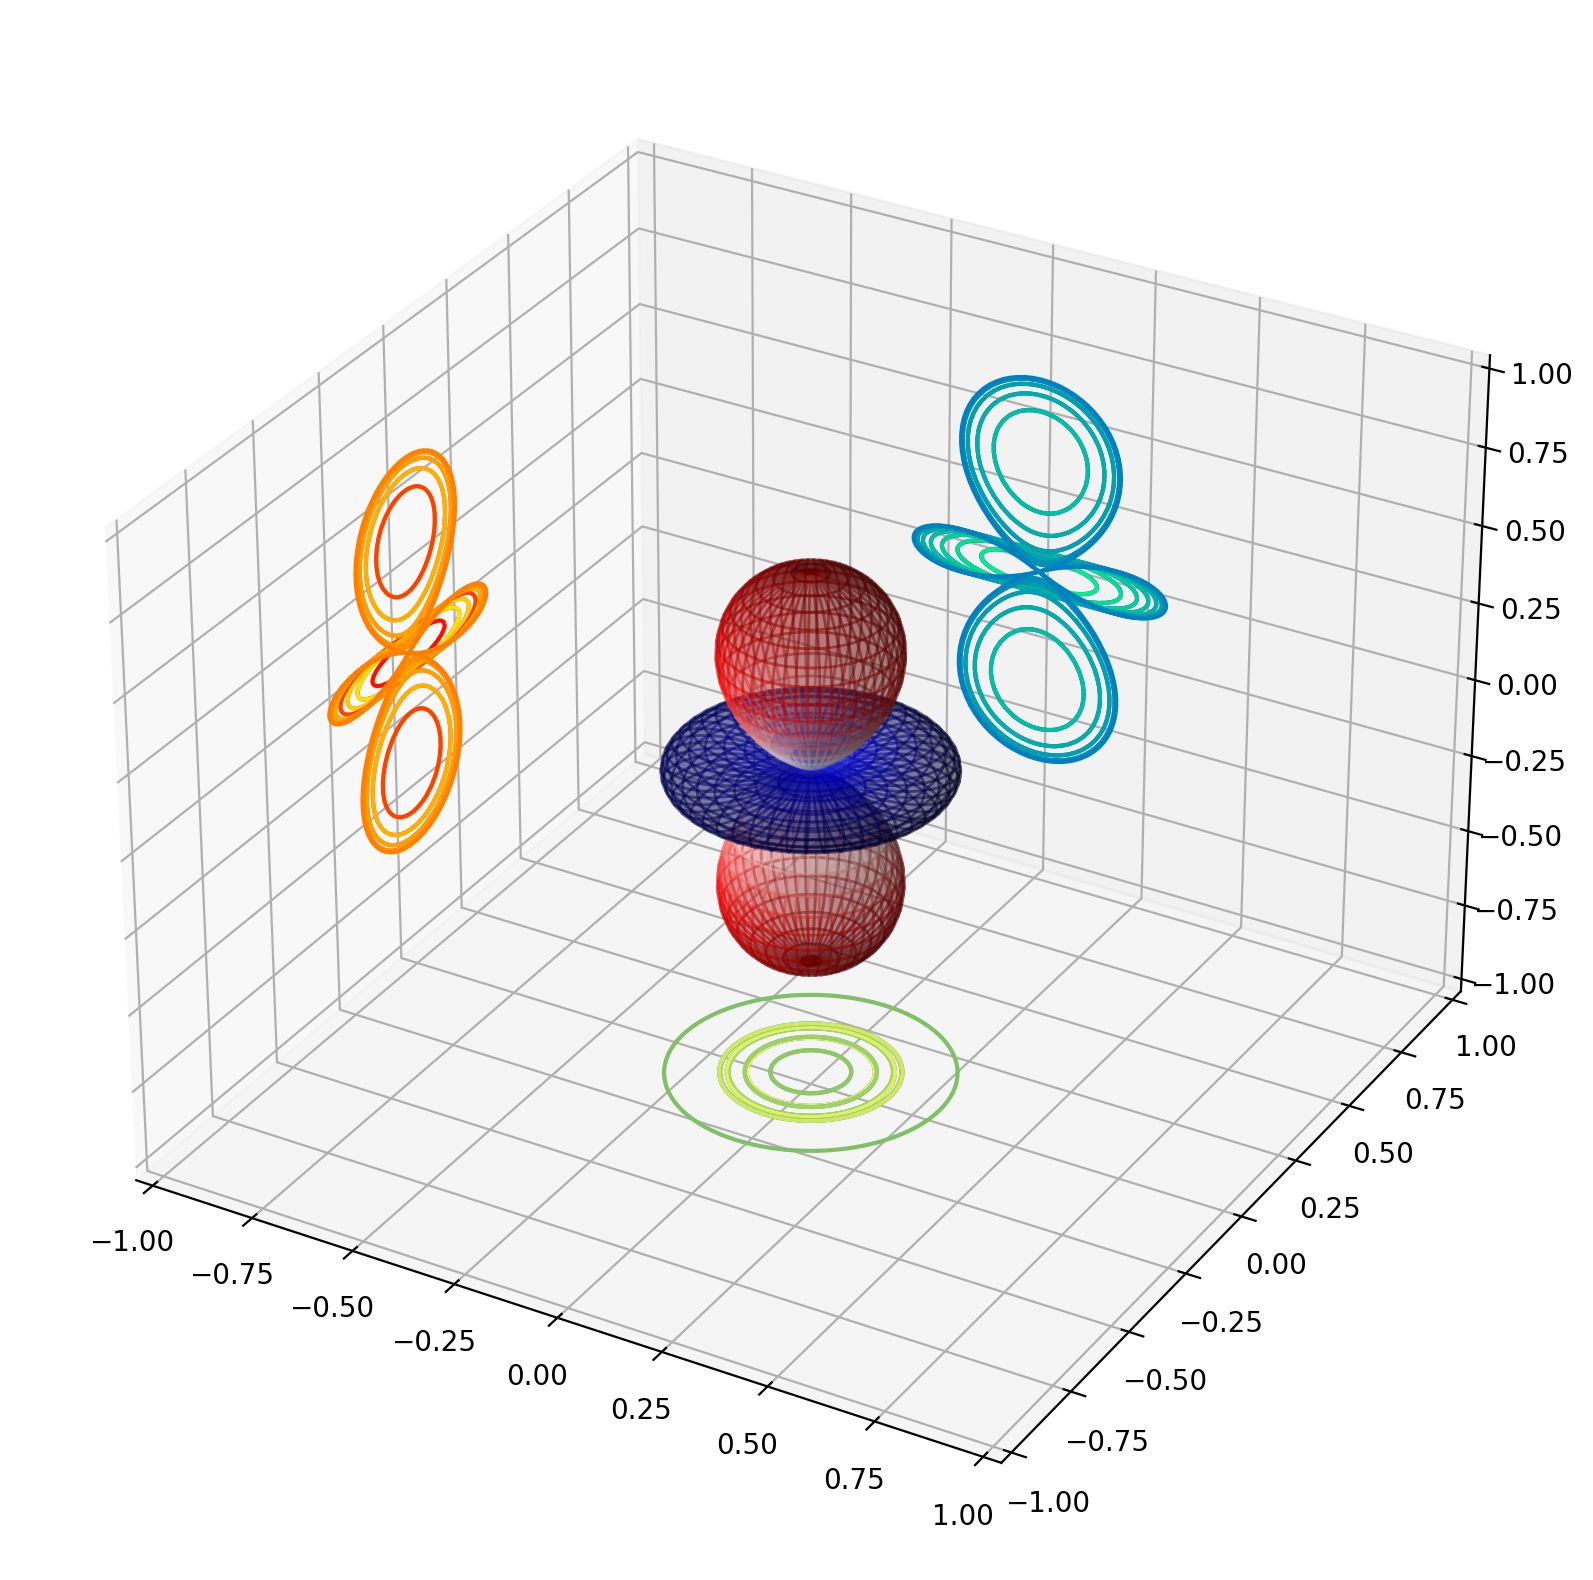

In [9]:
# Set up the 3D Canvas

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Normalize color bar to [0,1] scale

fcolors = (Ylm - Ylm.min()) /(Ylm.max() - Ylm.min())

# Make 3D plot of real part of spherical harmonic

ax.plot_surface(x, y, z, facecolors=cm.seismic(fcolors), alpha=0.3)


# Project 3D plot onto 2D planes

cset = ax.contour(x, y, z, 20, zdir='z', offset = -1, cmap='summer')
cset = ax.contour(x, y, z, 20, zdir='y', offset =  1, cmap='winter' )
cset = ax.contour(x, y, z, 20, zdir='x', offset = -1, cmap='autumn')


# Set axes limit to keep aspect ratio 1:1:1 

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()

## Plotting the full atomic orbitals

In [10]:
def HFunc(r, theta, phi, n, l, m):
    '''
    Hydrogen wavefunction: a = 1

    INPUT
        r: Radial coordinate
        phi: Polar coordinate
        theta: Azimuthal coordinate
        n: Principle quantum number
        l: Angular momentum quantum number
        m: Magnetic quantum number

    OUTPUT
        Value of wavefunction
    '''


    return psi_R(r,n,l) * psi_ang(phi,theta,l,m)


In [11]:
nmax = 10
lmax = nmax-1

@widgets.interact(n=np.arange(1,nmax,1), l = np.arange(0,nmax-1,1), m=np.arange(-lmax,lmax+1,1))

def psi_xz_plot(n=1,l=0,m=0):

    plt.figure(figsize=(10,8))
    
    
    limit = 4*(n+l) 
    
    x_1d = np.linspace(-limit,limit,500)
    z_1d = np.linspace(-limit,limit,500)
    
    x,z = np.meshgrid(x_1d,z_1d)
    y   = 0
    
    r     = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2+y**2), z )
    phi   = np.arctan2(y, x)

    
    psi_nlm = HFunc(r,theta,phi,n,l,m)
    
    #plt.pcolormesh(x, z, psi_nlm, cmap='inferno')  # Try cmap = inferno, rainbow, autumn, summer, 
    
    plt.contourf(x, z,  psi_nlm, 20, cmap='seismic', alpha=0.6)  # Classic orbitals
    
    plt.colorbar()
    
    plt.title(f"$n,l,m={n,l,m}$",fontsize=20)
    plt.xlabel('X',fontsize=20)
    plt.ylabel('Z',fontsize=20)


interactive(children=(Dropdown(description='n', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Dropdown(descri…

In [12]:
#Variables to adjust
maxi = 60
resolution = 160

base = np.linspace(-maxi, maxi, resolution)[:,np.newaxis,np.newaxis]
x2 = np.tile(base, (1,resolution,resolution))
y2 = np.swapaxes(x2,0,1)
z2 = np.swapaxes(x2,0,2)

total = np.concatenate((x2[np.newaxis,:],y2[np.newaxis,:],z2[np.newaxis,:]), axis=0)

r2 = np.linalg.norm(total, axis=0)
#Alternative theta calculation
#theta3 = np.abs(np.arctan2(np.linalg.norm(total[:2], axis=0),-total[2]))
np.seterr(all='ignore')
phi2 = np.arctan(np.divide(total[2],np.linalg.norm(total[:2], axis=0))) + np.pi/2
theta2 = np.arctan2(total[1],total[0])


In [ ]:
ipv.figure()

psi = HFunc(r2,theta2,phi2,2,1,1)

ipv.volshow(r2**2 * np.sin(phi2)*psi**2)

ipv.show()


In [ ]:
psi.shape
